In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils import data

from sklearn.preprocessing import MinMaxScaler

## HW1 Regression

**Address**: https://www.kaggle.com/c/ml2021spring-hw1

### Task Description

- COVID-19 daily cases prediction
- Training data: 2700 samples
- Testing data: 893 samples
- Evaluation metric: Root Mean Squared Error (RMSE)

---


Hyperparameters

In [2]:
split_ratio = .2
batch_size = 150
epochs = 800
lr = 0.1

Utils

In [3]:
def plot(arrays, labels = None, xlabel = None, ylabel = None, title = None, grid = True, save = False):
    assert type(arrays) == tuple
    plt.clf()
    for i in range(len(arrays)):
        if labels is not None:
            plt.plot(arrays[i], label = labels[i])
        else:
            plt.plot(arrays[i])
    if labels is not None:
        plt.legend()
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if grid:
        plt.grid()
    if save:
        plt.savefig('./' + title + '.png')

Read Data

In [4]:
train_raw = pd.read_csv('./Data/covid.train.csv')
test_raw = pd.read_csv('./Data/covid.test.csv')

Data Preprocess

In [5]:
def preprocess_data(train_raw, test_raw, split_ratio = 0.2):
    # Data Preprocess
    test_raw['temp'] = np.zeros_like(test_raw.iloc[:, 0])
    train_data = train_raw.values
    test_data = test_raw.values
    
    # Min-Max Scale
    scale = MinMaxScaler()
    train_scaled = scale.fit_transform(train_data)
    test_scaled = scale.transform(test_data)[:, :-1]
    
    # Split Data to Get Valid Set
    train_num = int((1 - split_ratio) * train_scaled.shape[0])
    train = torch.FloatTensor(train_scaled[:train_num, :])
    valid = torch.FloatTensor(train_scaled[train_num:, :])
    test = torch.FloatTensor(test_scaled)
    
    return train, valid, test, scale

train, valid, test, scale = preprocess_data(train_raw, test_raw)
print('train shape: {}'.format(train.shape))
print('valid shape: {}'.format(valid.shape))
print('test shape: {}'.format(test.shape))

train shape: torch.Size([2160, 95])
valid shape: torch.Size([540, 95])
test shape: torch.Size([893, 94])


Load Dataset

In [6]:
def load_Dataset(data_arrays, batch_size, shuffle = True):
    # Load Dataset
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle)

train_iter = load_Dataset((train[:, :-1], train[:, -1]), batch_size)
valid_iter = load_Dataset((valid[:, :-1], valid[:, -1]), batch_size)

Define model, loss and optimizer, and train.

epoch: 0, train loss: 0.816, test loss: 0.068
epoch: 1, train loss: 0.459, test loss: 0.055
epoch: 2, train loss: 0.385, test loss: 0.047
epoch: 3, train loss: 0.315, test loss: 0.036
epoch: 4, train loss: 0.286, test loss: 0.033
epoch: 5, train loss: 0.259, test loss: 0.031
epoch: 6, train loss: 0.233, test loss: 0.026
epoch: 7, train loss: 0.212, test loss: 0.027
epoch: 8, train loss: 0.204, test loss: 0.026
epoch: 9, train loss: 0.181, test loss: 0.025
epoch: 10, train loss: 0.188, test loss: 0.026
epoch: 11, train loss: 0.173, test loss: 0.026
epoch: 12, train loss: 0.175, test loss: 0.024
epoch: 13, train loss: 0.167, test loss: 0.025
epoch: 14, train loss: 0.158, test loss: 0.025
epoch: 15, train loss: 0.156, test loss: 0.027
epoch: 16, train loss: 0.153, test loss: 0.024
epoch: 17, train loss: 0.149, test loss: 0.023
epoch: 18, train loss: 0.143, test loss: 0.023
epoch: 19, train loss: 0.144, test loss: 0.024
epoch: 20, train loss: 0.136, test loss: 0.024
epoch: 21, train loss: 

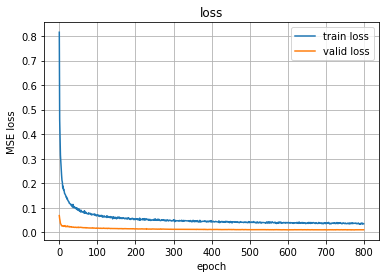

In [7]:
def train_model(model, loss, optimizer, train_iter, valid_iter, epochs):
    train_loss_list = []
    valid_loss_list = []
    for epoch in range(epochs):
        train_loss = 0
        model.train()
        for X, y in train_iter:
            l = loss(model(X).reshape(-1), y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_loss += float(l)
        train_loss_list.append(train_loss)
        
        valid_loss = 0
        model.eval()
        with torch.no_grad():
            for X, y in valid_iter:
                valid_loss += float(loss(model(X).reshape(-1), y))
            valid_loss_list.append(valid_loss)
        
        print(f'epoch: {epoch}, train loss: {train_loss:.3f}, test loss: {valid_loss:.3f}')
    
    plot((train_loss_list, valid_loss_list), labels = ('train loss', 'valid loss',),
         xlabel = 'epoch', ylabel = 'MSE loss', title = 'loss')
    
model = nn.Sequential(
    nn.Linear(94, 128), nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 128), nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 1)
)
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

train_model(model, loss, optimizer, train_iter, valid_iter, epochs)

On train set

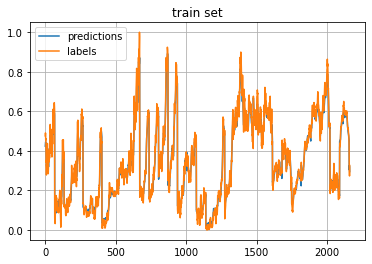

In [8]:
model.eval()
with torch.no_grad():
    train_pred = model(train[:, :-1]).reshape(-1)
    plot((train_pred, train[:, -1]), labels = ('predictions', 'labels'),
         title= 'train set')

On valid set

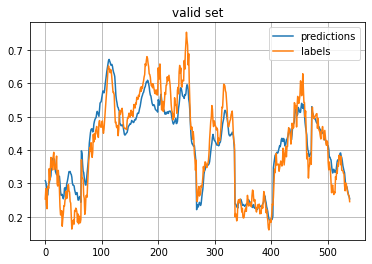

In [9]:
model.eval()
with torch.no_grad():
    valid_pred = model(valid[:, :-1]).reshape(-1)
    plot((valid_pred, valid[:, -1]), labels = ('predictions', 'labels'),
         title= 'valid set')

On test set:

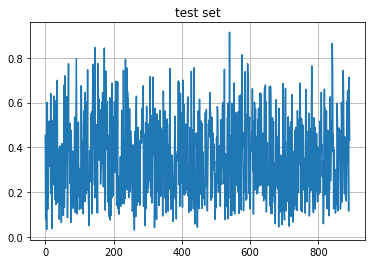

In [10]:
with torch.no_grad():
    test_pred = model(test).detach().numpy().reshape(-1)
    plot((test_pred,), title = 'test set')

inverse scale

In [11]:
temp = np.zeros_like(test_raw)
temp[:, -1] = test_pred
test_positive = scale.inverse_transform(temp)[:, -1]

Use `pandas` to get `Submission.csv`

In [12]:
id = range(len(test_pred))
Submission = pd.DataFrame(list(zip(id, test_positive)), 
                        columns = ['id', 'tested_positive'])
Submission.set_index(['id'], inplace = True)
Submission.to_csv('./Submission.csv')